Time-Series Prediction with RNNs using PyTorch

This notebook demonstrates how to train Recurrent Neural Networks (RNNs)
using PyTorch to predict future values in a time-series dataset.

It covers:
- Preprocessing and normalizing time-series data.
- Using sliding window techniques to create input-output pairs.
- Experimenting with different sequence lengths.
- Comparing Vanilla RNN, LSTM, and GRU.

Bonus: Provides a brief outline for implementing multivariate time-series prediction.

## Libraries

In [8]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

## 1. Data Loading and Preprocessing

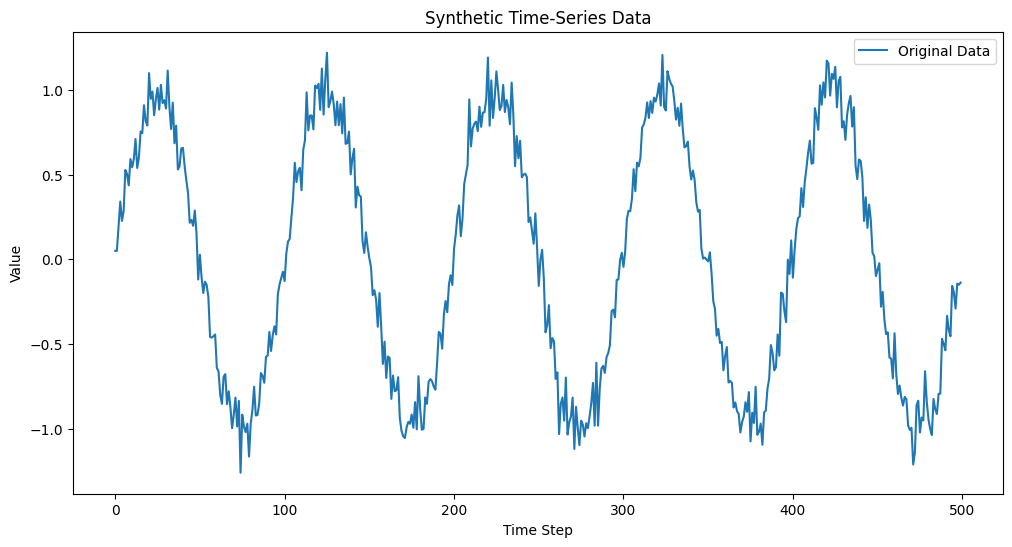

Training data size: 400
Testing data size: 100


In [9]:
# Generate a synthetic time-series dataset
np.random.seed(42)
time_steps = np.linspace(0, 10 * np.pi, 500)
data = np.sin(time_steps) + np.random.normal(0, 0.1, len(time_steps))
df = pd.DataFrame({'value': data})

# Visualize the time-series data
plt.figure(figsize=(12, 6))
plt.plot(df['value'], label='Original Data')
plt.title('Synthetic Time-Series Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(df['value'].values.reshape(-1, 1))

# Convert scaled data to a PyTorch tensor
scaled_data_tensor = torch.tensor(scaled_data, dtype=torch.float) # Add an extra dimension for features

# Split the data into training and testing sets
train_size = int(len(scaled_data_tensor) * 0.8)
train_data = scaled_data_tensor[:train_size]
test_data = scaled_data_tensor[train_size:]

print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")

## 2. Sliding Window Technique

In [10]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return torch.stack(xs), torch.stack(ys)

# Experiment with different sequence lengths
sequence_length = 20
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

print(f"Shape of training input sequences (X_train): {X_train.shape}")
print(f"Shape of training output values (y_train): {y_train.shape}")
print(f"Shape of testing input sequences (X_test): {X_test.shape}")
print(f"Shape of testing output values (y_test): {y_test.shape}")

Shape of training input sequences (X_train): torch.Size([380, 20, 1])
Shape of training output values (y_train): torch.Size([380, 1])
Shape of testing input sequences (X_test): torch.Size([80, 20, 1])
Shape of testing output values (y_test): torch.Size([80, 1])


## 3. Model Definitions

In [11]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        # Decode the final hidden state
        out = self.fc(out[:, -1, :])
        return out, hidden

    def init_hidden(self, batch_size, device):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        # Decode the final hidden state
        out = self.fc(out[:, -1, :])
        return out, hidden

    def init_hidden(self, batch_size, device):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))

class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.gru(x, hidden)
        # Decode the final hidden state
        out = self.fc(out[:, -1, :])
        return out, hidden

    def init_hidden(self, batch_size, device):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

## 4. Training and Evaluation

In [12]:
def train_model(model, X_train, y_train, X_test, y_test, learning_rate, num_epochs, batch_size, device):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = {'train_loss': [], 'val_loss': []}

    X_train_tensor = X_train.to(device)
    y_train_tensor = y_train.to(device)
    X_test_tensor = X_test.to(device)
    y_test_tensor = y_test.to(device)

    n_train_batches = len(X_train_tensor) // batch_size
    n_test_batches = len(X_test_tensor) // batch_size

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for i in range(n_train_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            inputs = X_train_tensor[start:end]
            targets = y_train_tensor[start:end]

            optimizer.zero_grad()
            hidden = model.init_hidden(inputs.size(0), device)
            outputs, hidden = model(inputs, hidden)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / n_train_batches
        history['train_loss'].append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i in range(n_test_batches):
                start = i * batch_size
                end = (i + 1) * batch_size
                inputs = X_test_tensor[start:end]
                targets = y_test_tensor[start:end]

                hidden = model.init_hidden(inputs.size(0), device)
                outputs, hidden = model(inputs, hidden)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        avg_val_loss = val_loss / n_test_batches
        history['val_loss'].append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return model, history

def predict_future(model, data, seq_length, future_steps, device):
    model.eval()
    predictions = []
    last_sequence = data[-seq_length:].unsqueeze(0).to(device)
    hidden = model.init_hidden(1, device)

    with torch.no_grad():
        for _ in range(future_steps):
            output, hidden = model(last_sequence, hidden)
            predictions.append(output.cpu().numpy()[0, 0])
            last_sequence = torch.cat((last_sequence[:, 1:, :], output.unsqueeze(0)), dim=1)

    return np.array(predictions)

# Hyperparameters
input_size = 1
hidden_size = 32
output_size = 1
num_layers = 2
learning_rate = 0.01
num_epochs = 50
batch_size = 16
future_steps = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize and train Vanilla RNN
vanilla_rnn = VanillaRNN(input_size, hidden_size, output_size, num_layers).to(device)
trained_vanilla_rnn, vanilla_history = train_model(vanilla_rnn, X_train, y_train, X_test, y_test, learning_rate, num_epochs, batch_size, device)

# Initialize and train LSTM
lstm_model = LSTM(input_size, hidden_size, output_size, num_layers).to(device)
trained_lstm, lstm_history = train_model(lstm_model, X_train, y_train, X_test, y_test, learning_rate, num_epochs, batch_size, device)

# Initialize and train GRU
gru_model = GRU(input_size, hidden_size, output_size, num_layers).to(device)
trained_gru, gru_history = train_model(gru_model, X_train, y_train, X_test, y_test, learning_rate, num_epochs, batch_size, device)

Epoch [1/50], Train Loss: 0.2228, Val Loss: 0.0210
Epoch [2/50], Train Loss: 0.0173, Val Loss: 0.0124
Epoch [3/50], Train Loss: 0.0120, Val Loss: 0.0120
Epoch [4/50], Train Loss: 0.0119, Val Loss: 0.0117
Epoch [5/50], Train Loss: 0.0102, Val Loss: 0.0110
Epoch [6/50], Train Loss: 0.0096, Val Loss: 0.0107
Epoch [7/50], Train Loss: 0.0099, Val Loss: 0.0133
Epoch [8/50], Train Loss: 0.0122, Val Loss: 0.0186
Epoch [9/50], Train Loss: 0.0286, Val Loss: 0.0609
Epoch [10/50], Train Loss: 0.0403, Val Loss: 0.0130
Epoch [11/50], Train Loss: 0.0130, Val Loss: 0.0126
Epoch [12/50], Train Loss: 0.0114, Val Loss: 0.0116
Epoch [13/50], Train Loss: 0.0111, Val Loss: 0.0111
Epoch [14/50], Train Loss: 0.0107, Val Loss: 0.0113
Epoch [15/50], Train Loss: 0.0116, Val Loss: 0.0116
Epoch [16/50], Train Loss: 0.0123, Val Loss: 0.0117
Epoch [17/50], Train Loss: 0.0129, Val Loss: 0.0132
Epoch [18/50], Train Loss: 0.0156, Val Loss: 0.0134
Epoch [19/50], Train Loss: 0.0125, Val Loss: 0.0138
Epoch [20/50], Train 

## 5. Visualization of Results

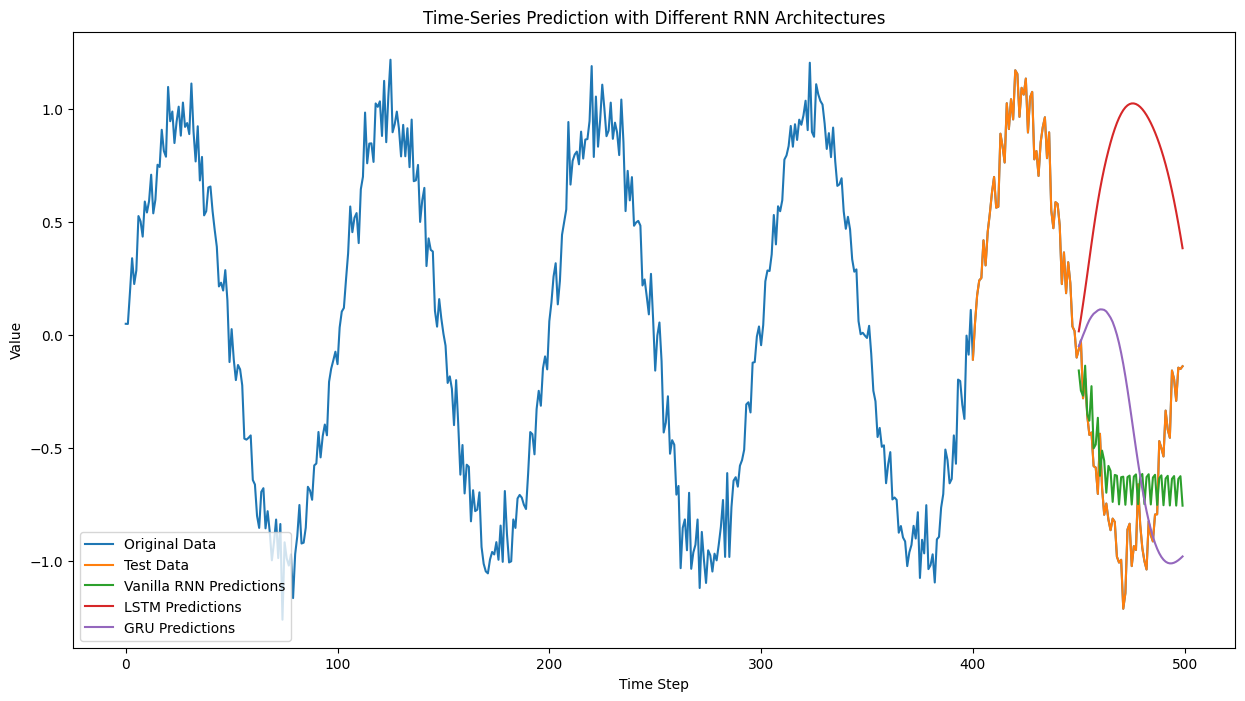

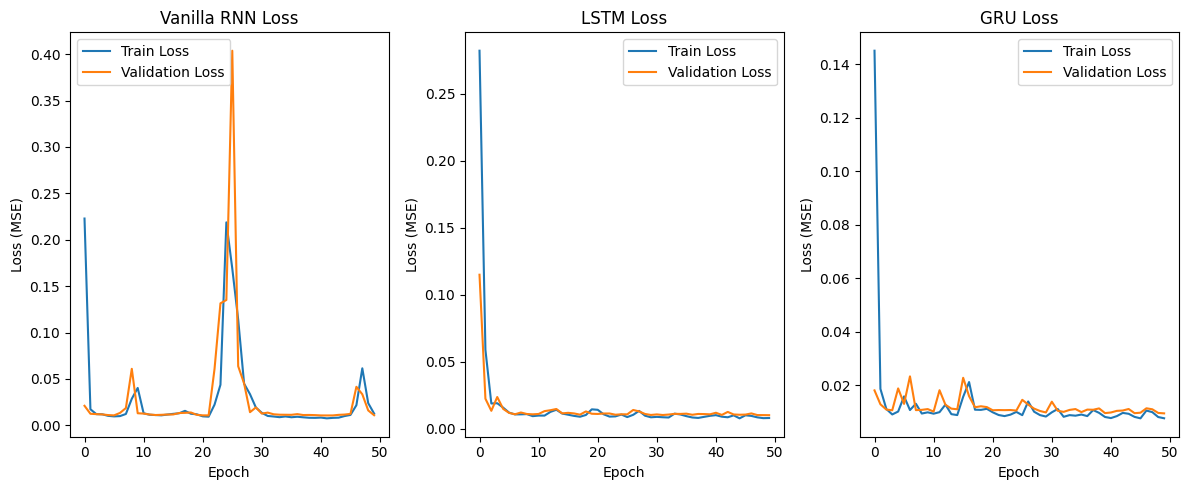


Mean Squared Error on Test Set:
Vanilla RNN: 0.0109
LSTM: 0.0103
GRU: 0.0095


In [13]:
# Make predictions
vanilla_predictions = predict_future(trained_vanilla_rnn, scaled_data_tensor, sequence_length, future_steps, device)
lstm_predictions = predict_future(trained_lstm, scaled_data_tensor, sequence_length, future_steps, device)
gru_predictions = predict_future(trained_gru, scaled_data_tensor, sequence_length, future_steps, device)

# Inverse transform the predictions to the original scale
original_predictions_vanilla = scaler.inverse_transform(np.concatenate((scaled_data[-sequence_length-future_steps:-future_steps], vanilla_predictions.reshape(-1, 1)))).flatten()
original_predictions_lstm = scaler.inverse_transform(np.concatenate((scaled_data[-sequence_length-future_steps:-future_steps], lstm_predictions.reshape(-1, 1)))).flatten()
original_predictions_gru = scaler.inverse_transform(np.concatenate((scaled_data[-sequence_length-future_steps:-future_steps], gru_predictions.reshape(-1, 1)))).flatten()
original_test_data = scaler.inverse_transform(test_data).flatten()

# Plot the results
plt.figure(figsize=(15, 8))
plt.plot(df['value'], label='Original Data')
plt.plot(range(len(df) - len(original_test_data), len(df)), original_test_data, label='Test Data')
plt.plot(range(len(df) - future_steps, len(df)), original_predictions_vanilla[-future_steps:], label='Vanilla RNN Predictions')
plt.plot(range(len(df) - future_steps, len(df)), original_predictions_lstm[-future_steps:], label='LSTM Predictions')
plt.plot(range(len(df) - future_steps, len(df)), original_predictions_gru[-future_steps:], label='GRU Predictions')
plt.title('Time-Series Prediction with Different RNN Architectures')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.plot(vanilla_history['train_loss'], label='Train Loss')
plt.plot(vanilla_history['val_loss'], label='Validation Loss')
plt.title('Vanilla RNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(lstm_history['train_loss'], label='Train Loss')
plt.plot(lstm_history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(gru_history['train_loss'], label='Train Loss')
plt.plot(gru_history['val_loss'], label='Validation Loss')
plt.title('GRU Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the models
def evaluate_model(model, X_test, y_test, device):
    model.eval()
    X_test_tensor = X_test.to(device)
    y_test_tensor = y_test.to(device)
    criterion = nn.MSELoss()
    with torch.no_grad():
        hidden = model.init_hidden(X_test_tensor.size(0), device)
        outputs, _ = model(X_test_tensor, hidden)
        mse = criterion(outputs, y_test_tensor).item()
    return mse

vanilla_mse = evaluate_model(trained_vanilla_rnn, X_test, y_test, device)
lstm_mse = evaluate_model(trained_lstm, X_test, y_test, device)
gru_mse = evaluate_model(trained_gru, X_test, y_test, device)

print(f"\nMean Squared Error on Test Set:")
print(f"Vanilla RNN: {vanilla_mse:.4f}")
print(f"LSTM: {lstm_mse:.4f}")
print(f"GRU: {gru_mse:.4f}")